<a href="https://colab.research.google.com/github/mohitsharmas97/Transfer_learning_models/blob/main/plantdiseasedetectionbypytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


In [2]:
cd /kaggle/input/plantdisease

/kaggle/input/plantdisease


In [3]:
ls

plantvillage/  PlantVillage/


In [4]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walkthrough_path='/kaggle/input/plantdisease'
walk_through(walkthrough_path)

There are 2 directories and 0 images in '/kaggle/input/plantdisease'.
There are 15 directories and 0 images in '/kaggle/input/plantdisease/PlantVillage'.
There are 0 directories and 997 images in '/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot'.
There are 0 directories and 152 images in '/kaggle/input/plantdisease/PlantVillage/Potato___healthy'.
There are 0 directories and 952 images in '/kaggle/input/plantdisease/PlantVillage/Tomato_Leaf_Mold'.
There are 0 directories and 3209 images in '/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus'.
There are 0 directories and 2127 images in '/kaggle/input/plantdisease/PlantVillage/Tomato_Bacterial_spot'.
There are 0 directories and 1771 images in '/kaggle/input/plantdisease/PlantVillage/Tomato_Septoria_leaf_spot'.
There are 0 directories and 1591 images in '/kaggle/input/plantdisease/PlantVillage/Tomato_healthy'.
There are 0 directories and 1676 images in '/kaggle/input/plantdisease/PlantVillag

In [6]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import transforms
from tqdm import tqdm

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [8]:
torch.manual_seed(42)

In [9]:
data_dir='/kaggle/input/plantdisease/PlantVillage'
learning_rate=0.001
epochs=10
batch_size=32

In [10]:
full_dataset=datasets.ImageFolder(data_dir)
class_names=full_dataset.classes
num_classes=len(class_names)
print(f"There are {num_classes} classes in the dataset: {class_names}")

There are 15 classes in the dataset: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [11]:
train_samples,test_samples=train_test_split(full_dataset,
                                            test_size=0.2,
                                            random_state=42,
                                            stratify=[s[1] for s in full_dataset.samples]
                                            )

In [12]:
custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        # Get the image and label from our list of samples
        image, label = self.samples[index]

        # Convert to 3-channel (RGB). This is the equivalent of `np.stack((image,)*3, axis=-1)`
        # in your notebook, ensuring the image has 3 channels for VGG16.
        image = image.convert('RGB')

        # Apply the transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [14]:
train_dataset=PlantDiseaseDataset(train_samples,transform=custom_transform)
test_dataset=PlantDiseaseDataset(test_samples,transform=custom_transform)

In [15]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [16]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:11<00:00, 46.6MB/s]


In [17]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [18]:
vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=num_classes),
)

In [19]:
vgg16 = vgg16.to(device)

In [20]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(vgg16.parameters(),lr=learning_rate)

In [21]:
for epoch in range(epochs):
  total_epoch_loss=0
  vgg16.train()

  for batch_features,batch_labels in tqdm(train_loader):
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    outputs=vgg16(batch_features)

    loss=criterion(outputs,batch_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss+=loss.item()

    avg_epoch_loss=total_epoch_loss/len(train_loader)

  print(f"Epoch: {epoch+1}/{epochs}..")
  print(f"Train loss: {avg_epoch_loss}")

100%|██████████| 516/516 [01:39<00:00,  5.19it/s]


Epoch: 1/10..
Train loss: 0.7726685860620219


100%|██████████| 516/516 [01:41<00:00,  5.09it/s]


Epoch: 2/10..
Train loss: 0.38890606004658135


100%|██████████| 516/516 [01:41<00:00,  5.10it/s]


Epoch: 3/10..
Train loss: 0.30885884527102575


100%|██████████| 516/516 [01:41<00:00,  5.09it/s]


Epoch: 4/10..
Train loss: 0.2695019746969938


100%|██████████| 516/516 [01:42<00:00,  5.05it/s]


Epoch: 5/10..
Train loss: 0.2457105776546848


100%|██████████| 516/516 [01:41<00:00,  5.07it/s]


Epoch: 6/10..
Train loss: 0.25608401563692684


100%|██████████| 516/516 [01:41<00:00,  5.09it/s]


Epoch: 7/10..
Train loss: 0.2396356803674139


100%|██████████| 516/516 [01:41<00:00,  5.09it/s]


Epoch: 8/10..
Train loss: 0.23939003099070577


100%|██████████| 516/516 [01:41<00:00,  5.08it/s]


Epoch: 9/10..
Train loss: 0.24778331657312389


100%|██████████| 516/516 [01:41<00:00,  5.09it/s]

Epoch: 10/10..
Train loss: 0.2080780368422604


In [24]:
print("\nEvaluating on Test Set...")
total = 0
correct = 0
vgg16.eval() # Set model to evaluation mode

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = vgg16(batch_features)
        predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted.indices == batch_labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy*100:.2f}%')


Evaluating on Test Set...
Test Accuracy: 94.23%


In [25]:
print("\nEvaluating on Train Set...")
total = 0
correct = 0
vgg16.eval() # Set model to evaluation mode

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = vgg16(batch_features)
        predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted.indices == batch_labels).sum().item()

accuracy = correct / total
print(f'Training Accuracy: {accuracy*100:.2f}%')


Evaluating on Train Set...
Training Accuracy: 99.45%


In [28]:
MODEL_DIR = "/content/models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "plant_disease_model_vgg16.pth")

# Save the model's state dictionary
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"\n✅ Model saved successfully at: {MODEL_PATH}")


✅ Model saved successfully at: /content/models/plant_disease_model_vgg16.pth


In [29]:
from google.colab import files

files.download(MODEL_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
transformed_images = []
for image_path in random_image_paths:
    image = Image.open(image_path)
    transformed_image = custom_transform(image)
    transformed_images.append(transformed_image)

input_tensor = torch.stack(transformed_images)
input_tensor = input_tensor.to(device)

In [32]:
vgg16.eval()

with torch.no_grad():
    outputs = vgg16(input_tensor)
    predicted_indices = torch.max(outputs, 1).indices

predicted_indices = predicted_indices.cpu()

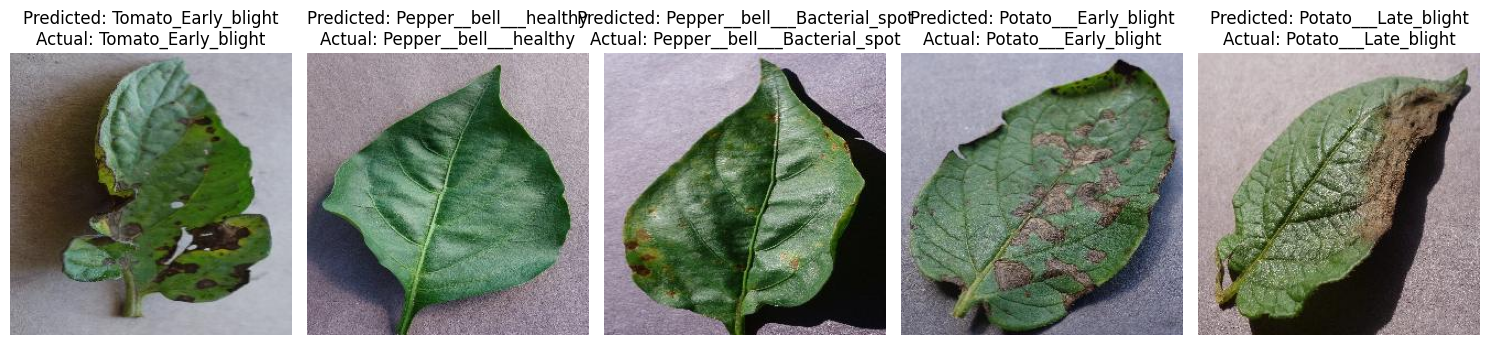

In [34]:
plt.figure(figsize=(15, 10))
for i in range(len(random_image_paths)):
    image_path = random_image_paths[i]
    predicted_class_index = predicted_indices[i].item()
    predicted_class_name = class_names[predicted_class_index]

    # Get the actual class label from the full_dataset
    # The full_dataset.samples list contains tuples of (image_path, label_index)
    actual_class_index = [s[1] for s in full_dataset.samples if s[0] == image_path][0]
    actual_class_name = class_names[actual_class_index]

    img = Image.open(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}\nActual: {actual_class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()